# Decision Tree

In [42]:
import pandas as pd
import numpy as np
from graphviz import Digraph
from sklearn.preprocessing import LabelEncoder

Récupération des datas d'entraînements utilisées par Ross Quinlan en 1989 (Weather dataset).

In [43]:
raw_data = {
    'Outlook': ['Sunny', 'Sunny', 'Overcast', 'Rainy', 'Rainy', 'Rainy', 'Overcast', 'Sunny', 'Sunny', 'Rainy', 'Sunny', 'Overcast', 'Overcast', 'Rainy'],
    'Temperature': ['Hot', 'Hot', 'Hot', 'Mild', 'Cool', 'Cool', 'Cool', 'Mild', 'Cool', 'Mild', 'Mild', 'Mild', 'Hot', 'Mild'],
    'Humidity': ['High', 'High', 'High', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'Normal', 'Normal', 'High', 'Normal', 'High'],
    'Windy': [False, True, False, False, False, True, True, False, False, False, True, True, False, True],
    'Play': ['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes', 'Yes', 'Yes', 'Yes', 'No']
}

df = pd.DataFrame(raw_data)
data = df.to_numpy()

df

,Outlook,Temperature,Humidity,Windy,Play
0,Sunny,Hot,High,False,No
1,Sunny,Hot,High,True,No
2,Overcast,Hot,High,False,Yes
3,Rainy,Mild,High,False,Yes
4,Rainy,Cool,Normal,False,Yes
5,Rainy,Cool,Normal,True,No
6,Overcast,Cool,Normal,True,Yes
7,Sunny,Mild,High,False,No
8,Sunny,Cool,Normal,False,Yes
9,Rainy,Mild,Normal,False,Yes


## Critères de décisions (Entropy et Gini)

Ici $p_i(x)$ est la proba de la valeur $x$ de la caractéristique $i$. 

Par exemple :
- $p_{\tiny\text{Outlook}}(\text{Sunny}) = \frac{5}{14}$
- $p_{\tiny\text{Outlook}}(\text{Overcast}) = \frac{4}{14}$
- $p_{\tiny\text{Outlook}}(\text{Rainy}) = \frac{5}{14}$

In [45]:
# Takes data as input and returns: (probabilities, raw_counts, total_size)
def node_stats(dataframe, target_feature):
    counts = {}
    subset_size = len(dataframe)
    for value in dataframe[target_feature]:
        if value in counts:
            counts[value] += 1
        else:
            counts[value] = 1

    probs = [count / subset_size for count in counts.values()]
    return np.array(probs), np.array(list(counts.values())), subset_size

stats = node_stats(df, 'Windy')

stats

(array([0.57142857, 0.42857143]), array([8, 6]), 14)

In [46]:
def entropy(dist):
    return -np.sum(dist*np.log2(dist))

def gini(dist):
    return -np.sum(dist**2)

# Gain is calculated for one specific feature (already in parents/children_stats)
def gain(parent_stats, children_stats): # children_dist = [child_dist_1, ..., child_dist_n]
    parent_entropy = entropy(parent_stats[0])
    parent_size = parent_stats[2]

    weighted_children_entropy = 0
    for child_stats in children_stats:
        weights = child_stats[2] / parent_size
        weighted_children_entropy += weights * entropy(child_stats[0])

    return parent_entropy - weighted_children_entropy

entropy(stats[0])

np.float64(0.9852281360342515)

In [47]:
# test of gain
parent_stats = node_stats(df, 'Play')
children_stats = [] # stats with the feature Windy
for value in df['Windy'].unique():
    subset =  df[df['Windy'] == value]
    stats = node_stats(subset, 'Play') # Sachant le node d'avant donc ici 'Play'
    children_stats.append(stats)

gain(parent_stats, children_stats)


np.float64(0.04812703040826949)

In [48]:
parent_stats = node_stats(df, 'Play')
for feature in list(df)[:-1]:
    children_stats = [] # stats with the feature Windy
    for value in df[feature].unique():
        subset =  df[df[feature] == value]
        stats = node_stats(subset, 'Play') # Sachant le node d'avant donc ici 'Play'
        children_stats.append(stats)
    
    print(gain(parent_stats, children_stats))


0.24674981977443933
0.02922256565895487
0.15183550136234159
0.04812703040826949


## Algorithme ID3

In [49]:
def ID3(dataframe, target_feature, features, depth=0, max_depth=5, min_samples=2):

    # Current node stats (it's a recursive function)
    parent_stats = node_stats(dataframe, target_feature)
    
    # Stopping conditions
    if len(parent_stats[0]) == 1:
        return dataframe[target_feature].iloc[0]
    
    if len(parent_stats[0]) == 0 or depth >= max_depth:
        return dataframe[target_feature].value_counts().idxmax() # Find the majority class

    if parent_stats[2] < min_samples:
        return dataframe[target_feature].value_counts().idxmax() # Find the majority class

    # Best feature
    max_gain = -1
    best_feature = None
    for feature in features:
        children_stats = []
        for value in dataframe[feature].unique():
            subset =  dataframe[dataframe[feature] == value]
            children_stats.append(node_stats(subset, target_feature))

        current_gain = gain(parent_stats, children_stats)

        if current_gain > max_gain:
            max_gain = current_gain
            best_feature = feature

    if best_feature is None or max_gain <= 0:
        return dataframe[target_feature].value_counts().idxmax() # Return majority class

    # Build the tree
    tree = {best_feature: {}}
    remaining_features = [f for f in features if f != best_feature]

    for value in dataframe[best_feature].unique():
        subset = dataframe[dataframe[best_feature] == value]
        subtree = ID3(subset, target_feature, remaining_features, depth + 1, max_depth, min_samples)

        tree[best_feature][value] = subtree
    
    return tree


## Utilisation et visualisation sur notre dataset

ici `target_feature = 'play'` car on veut décider quand jouer et quand ne pas jouer.

In [50]:
# Initialisation
x = data[:,:4] # Training set
y = list(df)[:-1] # Set of features
labels = data[:,4] # Set of every labels

x,y,labels

(array([['Sunny', 'Hot', 'High', False],
        ['Sunny', 'Hot', 'High', True],
        ['Overcast', 'Hot', 'High', False],
        ['Rainy', 'Mild', 'High', False],
        ['Rainy', 'Cool', 'Normal', False],
        ['Rainy', 'Cool', 'Normal', True],
        ['Overcast', 'Cool', 'Normal', True],
        ['Sunny', 'Mild', 'High', False],
        ['Sunny', 'Cool', 'Normal', False],
        ['Rainy', 'Mild', 'Normal', False],
        ['Sunny', 'Mild', 'Normal', True],
        ['Overcast', 'Mild', 'High', True],
        ['Overcast', 'Hot', 'Normal', False],
        ['Rainy', 'Mild', 'High', True]], dtype=object),
 ['Outlook', 'Temperature', 'Humidity', 'Windy'],
 array(['No', 'No', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'No', 'Yes', 'Yes',
        'Yes', 'Yes', 'Yes', 'No'], dtype=object))

In [51]:
# Usage of ID3
tree = ID3(df, 'Play', y)

tree

{'Outlook': {'Sunny': {'Humidity': {'High': 'No', 'Normal': 'Yes'}},
  'Overcast': 'Yes',
  'Rainy': {'Windy': {np.False_: 'Yes', np.True_: 'No'}}}}

In [52]:
# Visualisation (Ai generated code)

def render_tree(tree):
    dot = Digraph(format='png')
    
    def add_nodes(current_tree, parent_node_id=None, edge_label=None):
        # 1. CAS FEUILLE : Si current_tree est une simple chaîne ('Yes' / 'No')
        if not isinstance(current_tree, dict):
            node_id = str(hash(parent_node_id + str(edge_label) + str(current_tree)))
            dot.node(node_id, str(current_tree), shape='ellipse', style='filled', color='lightgreen')
            if parent_node_id:
                dot.edge(parent_node_id, node_id, label=str(edge_label))
            return

        # 2. CAS NOEUD : current_tree est un dictionnaire {'Feature': {branches...}}
        feature_name = list(current_tree.keys())[0]
        node_id = str(hash(feature_name + str(parent_node_id) + str(edge_label)))
        
        # Dessiner le nœud de la caractéristique
        dot.node(node_id, feature_name, shape='box', style='filled', color='lightblue')
        
        # Relier au parent si on n'est pas à la racine
        if parent_node_id:
            dot.edge(parent_node_id, node_id, label=str(edge_label))
        
        # 3. RÉCURSION : Parcourir les branches
        branches = current_tree[feature_name]
        for branch_value, child_subtree in branches.items():
            add_nodes(child_subtree, node_id, branch_value)

    # Lancer la récursion à partir de la racine
    add_nodes(tree)
    return dot

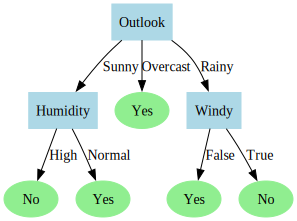

In [53]:
graph = render_tree(tree)

graph

Il y a un problème à l'utilisation de label textuel car l'arbre n'est pas dichotomique, on ne fixe pase de seuil de valeur, on va reconstruire l'arbre en utilisant des valeurs numériques à la place de nos valeurs textuelles.

```py
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_encoded = df.apply(le.fit_transform)
```

Ce qui permet de dire que $\text{Sunny} := 2$, $\text{Overcast} := 0$ et $\text{Rainy} := 1$.

Il faut modifier l'algorithme ID3 (qui peut utiliser seulement des attributs catégoriques et pas numériques) qui dans sa version initiale traite individuellement chaque valeur différente dans les features.

## Applications sur de vrai dataset

In [19]:
df = pd.read_csv('data/drug200.csv')

df

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


In [28]:
df.dtypes

Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object

In [20]:
tree = ID3(df, 'Drug', list(df)[:-1], max_depth=5, min_samples=3)

In [21]:
graph = render_tree(tree)

graph

Je laisse ce fail ici, car cela pointe un défaut de mon implémentation. En effet, quand j'utilise le `.unique()` pour récupérer les valeurs dans une feature particulière et bien ici il va créer autant de branche que de valeur et donc 200 car `Na_to_K` et `Age` est une valeur numérique. Je vais réfléchir à une solution, genre un treshold.

Test du programme sans la colonne `Na_to_K` et `Age` afin de voir s'il fonctionne.

In [16]:
df = df.drop(columns=['Age', 'Na_to_K'])

df

,Sex,BP,Cholesterol,Drug
0,F,HIGH,HIGH,drugY
1,M,LOW,HIGH,drugC
2,M,LOW,HIGH,drugC
3,F,NORMAL,HIGH,drugX
4,F,LOW,HIGH,drugY
...,...,...,...,...
195,F,LOW,HIGH,drugC
196,M,LOW,HIGH,drugC
197,M,NORMAL,HIGH,drugX
198,M,NORMAL,NORMAL,drugX


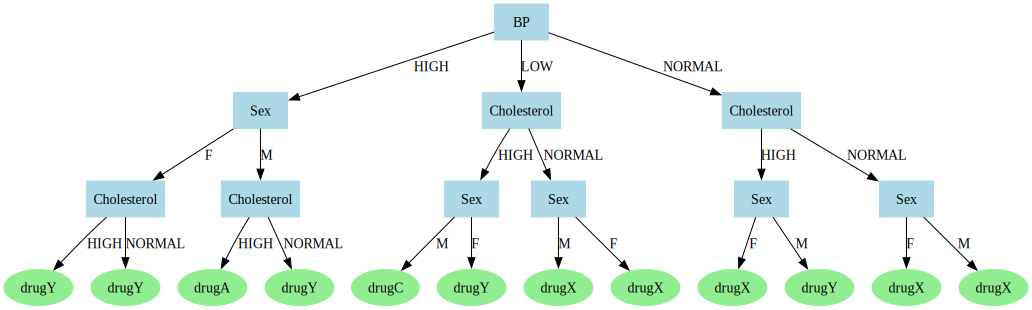

In [247]:
tree = ID3(df, 'Drug', list(df)[:-1], max_depth=5, min_samples=5)

render_tree(tree)

## Algorithme CART